Cow Detection Models

This code written by 
Qutaiba Olayyan Github: 
github.com/SwAt1563


Import the needed libraries

In [1]:
import pandas as pa
import numpy as np
from PIL import Image
from IPython.display import Image as im
from sklearn.feature_extraction import image as patch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import random
from warnings import simplefilter
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

Define the folders paths

In [2]:
# The path of training photos names
training_images_file_names = "data/train_images.txt"

# The path of testing photo name
# Note: It should be just one photo name for testing
# otherwise: will make error
testing_images_file_names = "data/test_images.txt"

# The path of dictionary that include all photos
images_dictionary = "data/images/"

# The path for save the predict testing image
output_path = "predictedImage.bmp"


Define constant parameters

In [3]:
# The size of each patch
PATCH_SIZE = (17, 17)

# The colors that we want to make features vectors depend on it
COLORS = ("red", "green", "blue")
CHANNEL_IDS = (0, 1, 2)

# For save the height and weight of the testing photo
testing_image_sizes = {}

Load Images for Training And Testing

In [4]:
def load_images(names_path, images_path, TYPE='TRAIN'):
    images = []
    names = []
    with open(names_path, 'r') as f:
        for line in f.readlines():
            names.append(tuple(line.replace("\n", "").split(" ")))
    
    for name in names:
        x_input = Image.open(f'{images_path}{name[0]}')
        x_input = np.array(x_input)

        y_output = Image.open(f'{images_path}{name[1]}')
        y_output = np.array(y_output)

        # for return the testing image from the patches
        # we need the height and width of the original image
        if TYPE == 'TEST':
            shape = x_input.shape
            height = shape[0]
            width = shape[1]
            testing_image_sizes['height'] = height
            testing_image_sizes['width'] = width

        images.append((x_input, y_output))
        
    return images

# training images and testing image as arrays
training_images = load_images(training_images_file_names, images_dictionary)
testing_images = load_images(testing_images_file_names, images_dictionary, 'TEST')


Extract Features Vector For Patch 

In [5]:
def get_features_vector(p):
    '''
    # p : patch (17, 17)
    # return 192 dimensional features vector
    # depend on the RGP of the patch

    In our colour histogram program, we are using a tuple, (channel_id, c), as the for variable.
    The first time through the loop, the channel_id variable takes the value 0,
    referring to the position of the red colour channel, and the c variable contains the string "red".
    The second time through the loop the values are the green channels position and "green",
    and the third time they are the blue channel position and "blue".

    Reference: https://datacarpentry.org/image-processing/05-creating-histograms/
    '''


    count = {}
    number_of_colors = 3

    for i in range(number_of_colors):
        histogram, bin_edges = np.histogram(
            p[:, :, CHANNEL_IDS[i]], bins=256, range=(0, 256))
        count[COLORS[i]] = histogram.copy()

        # you can use this command for plot the histogram
        # plt.plot(bin_edges[:-1], histogram, color=COLORS[i])
        # plt.show()

    features_vector = []

    '''
    For each of the RGB channels, create a histogram with 64 bins, where bin i contains the number of
    pixels with intensity value in the range [i*4, (i+1)*4), and 0 <= i < 64
    '''
    for i in range(number_of_colors):
        count[COLORS[i]] = [sum(count[COLORS[i]][j * 4: (j + 1) * 4])
                            for j in range(64)]
        features_vector.extend(count[COLORS[i]])

    return features_vector

Create The Training DataFrame 

In [6]:
def create_training_table(images):
    '''
    create DataFrame of features vectors with the targets
    for the training images
    '''
    data = {}

    # 192 dimensional features vector
    for i in range(192):
        data[i] = []

    # the target
    data['classifier'] = []

    for t_img in images:
        input_x = t_img[0]  # RGB  PHOTO (features vectors)
        output_y = t_img[1]  # BLACK AND WHITE PHOTO (target)

        # convert the images to patches
        input_patch = patch.extract_patches_2d(input_x, PATCH_SIZE)
        output_patch = patch.extract_patches_2d(output_y, PATCH_SIZE)

        number_of_patches = len(input_patch)

        connect_patches = []
        for i in range(number_of_patches):
            connect_patches.append((input_patch[i], output_patch[i]))

        random.shuffle(connect_patches)

        # [Grass = 3, Water = 2, Cow = 1, Others = 0]
        max_color = {0: 0, 1: 0, 2: 0, 3: 0}
        max_number = 1500

        for i in range(number_of_patches):

            # point each features vector with the target
            classifier = connect_patches[i][1][9][9]

            if max_color[classifier] > max_number:
                continue
            else:
                max_color[classifier] += 1

            # get the features vector for each patch
            f_v = get_features_vector(connect_patches[i][0])

            for j in range(192):
                data[j].append(f_v[j])

            data['classifier'].append(classifier)

    db = pa.DataFrame(data)

    # return after shuffle the data
    db_shuffle = db.sample(frac=1)
    return db_shuffle






Divide the features vectors and the targets between training and validation data

In [7]:
patches_db = create_training_table(training_images)

train_db, valid_db = train_test_split(patches_db, test_size=0.1)

x_train = train_db.drop('classifier', axis=1)
y_train = train_db.classifier

x_valid = valid_db.drop('classifier', axis=1)
y_valid = valid_db.classifier


In [8]:
# create DataFrame of features vectors with the targets
# for the testing image
def create_testing_table(test_images):
    data = {}

    # 192 dimensional features vectors
    for i in range(192):
        data[i] = []

    # the target
    data['classifier'] = []

    input_x = test_images[0][0]  # RGB  PHOTO (features vectors)
    output_y = test_images[0][1]  # BLACK AND WHITE PHOTO (target)

    # convert the images to patches
    input_patch = patch.extract_patches_2d(input_x, PATCH_SIZE)
    output_patch = patch.extract_patches_2d(output_y, PATCH_SIZE)

    number_of_patches = len(input_patch)

    for i in range(number_of_patches):

        # get the features vector for each patch
        f_v = get_features_vector(input_patch[i])

        # point each features vector with the target
        classifier = output_patch[i][9][9]

        for j in range(192):
            data[j].append(f_v[j])

        data['classifier'].append(classifier)

    db = pa.DataFrame(data)

    return db


Divide the features vectors and the targets for the testing data

In [9]:
test_db = create_testing_table(testing_images)
x_test = test_db.drop('classifier', axis=1)
y_test = test_db.classifier

Get the Result Image

In [10]:
def get_Image(y_predict):

    # for convert from [0, 1] colors to RGP colors
    dec = {0: [0,0,0], 1: [168,122,53],
        2: [0,0,255], 3: [0,255,0]}

    targets = list(y_predict.tolist())
    number_of_targets = len(targets)
    
    for i in range(number_of_targets):
        targets[i]=dec[targets[i]]
    
    targets_to_patches = []
    for i in range(number_of_targets):
        targets_to_patches.append(
            [[targets[i] for _ in range(17)] for _ in range(17)])
    
    testing_patches = np.array(targets_to_patches)
    testing_output_array = patch.reconstruct_from_patches_2d(
        testing_patches, (testing_image_sizes['height'], testing_image_sizes['width'], 3))
   
   
        
    testing_output_array = np.array(testing_output_array)
    testing_output_array = testing_output_array.astype(np.uint8)

    arr_to_img = Image.fromarray(testing_output_array, mode='RGB')
    arr_to_img.save(output_path)


Get results

In [11]:
# For find the accuracy score of the model
def cal_acc(y_actual, y_predict):
    return accuracy_score(y_actual, y_predict)


# FOR PRINT THE ACCURACY
def print_score(y_actual, y_predict):
    acc = cal_acc(y_actual, y_predict)
    print("Accuracy_TEST: ", np.round(acc, 3))
    

# for predict the result depend on the model
def predict_the_data(model, data):
    return model.predict(data)


Plot confusion Matrix

In [12]:
def plot_conf_matrix(conf_matrix):
   fig, ax = plt.subplots(figsize=(7.5, 7.5))
   ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
   for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
    
   plt.xlabel('Predictions', fontsize=18)
   plt.ylabel('Actuals', fontsize=18)
   plt.title('Confusion Matrix', fontsize=18)
   plt.show()
    

Cross Validation

In [13]:
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# for return the best parameters
def K_flode(model,param_grid):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid)
    grid_search.fit(x_valid, y_valid)
    best_parameters=grid_search.best_params_
    return best_parameters

KNN Model

In [14]:
def best_KNN():
    model = KNeighborsClassifier()
    param_grid = {
        'n_neighbors': [1, 3, 5]
        }
    best_values = K_flode(model, param_grid)
    print(f"the best hyperparameters is :\n {best_values}")
    return best_values
best_values_KNN=best_KNN()

the best hyperparameters is :
 {'n_neighbors': 1}


Accuracy_Train=1.0
Accuracy_TEST:  0.9
Confusion Matrix


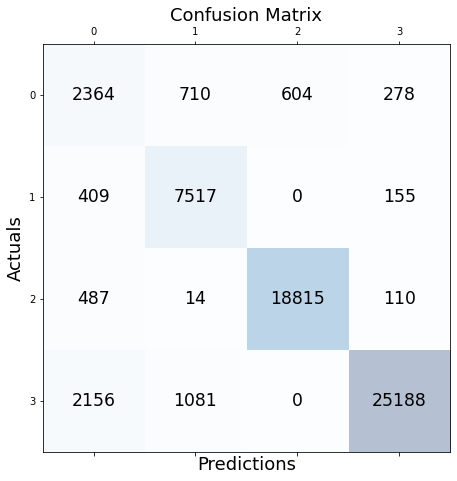

In [29]:

classifier = KNeighborsClassifier(
    n_neighbors=best_values_KNN['n_neighbors'])
classifier.fit(x_train, y_train)
print(f"Accuracy_Train={classifier.score(x_train,y_train)}")
y_predict = predict_the_data(classifier, x_test)
print_score(y_test, y_predict)
get_Image(y_predict=y_predict)
print("Confusion Matrix")
plot_conf_matrix(confusion_matrix(y_test, y_predict))



Result Image


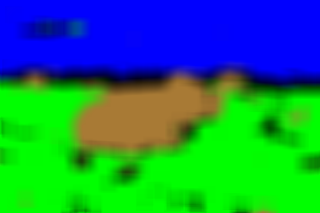

In [30]:
print("Result Image")
im(filename="predictedImage.png")

Descsion Tree Model

In [17]:
def best_dtree():
    model = DecisionTreeClassifier()
    param_grid = {
        'max_depth': [50, 120, 192]
        }
    best_values = K_flode(model, param_grid)
    print(f"the best hyperparameters is :\n {best_values}")
    return best_values
best_values_dt=best_dtree()

the best hyperparameters is :
 {'max_depth': 50}


Accuracy_Train=0.8693499440983868
Accuracy_TEST:  0.769
Confusion Matrix


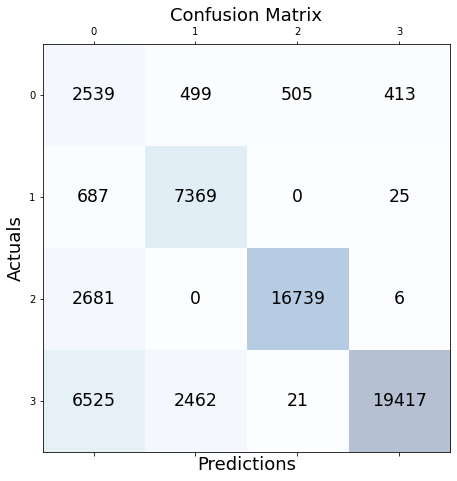

In [31]:
classifier = DecisionTreeClassifier(
    max_depth=best_values_dt['max_depth'], ccp_alpha=0.001)
classifier.fit(x_train, y_train)
print(f"Accuracy_Train={classifier.score(x_train,y_train)}")
y_predict = predict_the_data(classifier, x_test)
print_score(y_test, y_predict)
get_Image(y_predict=y_predict)
print("Confusion Matrix")
plot_conf_matrix(confusion_matrix(y_test, y_predict))


Result Image


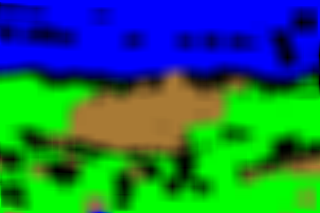

In [32]:
print("Result Image")
im(filename="predictedImage.png")

Logistic Regresion Model

In [20]:
def best_lr():
    model = LogisticRegression(max_iter=10000)
    
    param_grid = {
        'C': [0.1,0.2,0.3,0.4]
        }
    best_values = K_flode(model, param_grid)
    print(f"the best hyperparameters is :\n {best_values}")
    return best_values
best_values_lr=best_lr()

the best hyperparameters is :
 {'C': 0.1}


Accuracy_Train=0.9009476654421551
Accuracy_TEST:  0.869
Confusion Matrix


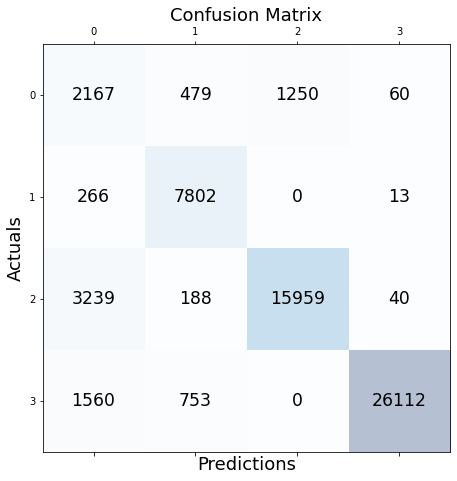

In [33]:
classifier = LogisticRegression(
    C=best_values_lr['C'], max_iter=10000)
classifier.fit(x_train, y_train)
print(f"Accuracy_Train={classifier.score(x_train,y_train)}")
y_predict = predict_the_data(classifier, x_test)
print_score(y_test, y_predict)
get_Image(y_predict=y_predict)
print("Confusion Matrix")
plot_conf_matrix(confusion_matrix(y_test, y_predict))


Result Image


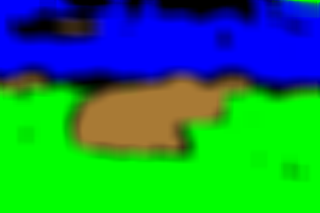

In [34]:
print("Result Image")
im(filename="predictedImage.png")

Random Forest Model

In [23]:
def best_random_forest():
    model = RandomForestClassifier()
    param_grid = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [2, 50, 100, 300]
    }
    best_values = K_flode(model, param_grid)
    print(f"the best hyperparameters is :\n {best_values}")
    return best_values


best_values_rf = best_random_forest()


the best hyperparameters is :
 {'max_depth': 50, 'n_estimators': 300}


Accuracy_Train=1.0
Accuracy_TEST:  0.935
Confusion Matrix


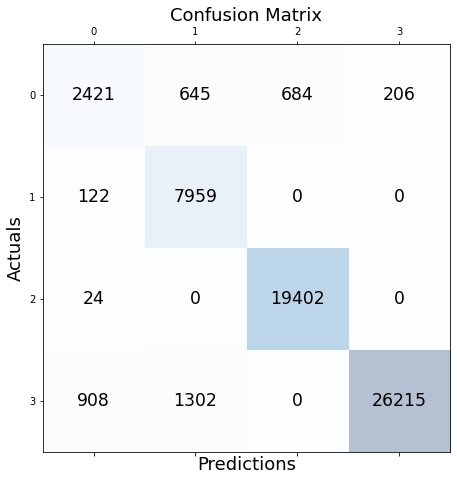

In [35]:

classifier = RandomForestClassifier(
    max_depth=best_values_rf['max_depth'], n_estimators=best_values_rf['n_estimators'])
classifier.fit(x_train, y_train)
print(f"Accuracy_Train={classifier.score(x_train,y_train)}")
y_predict = predict_the_data(classifier, x_test)
print_score(y_test, y_predict)
testing_image_sizes
get_Image(y_predict=y_predict)
print("Confusion Matrix")
plot_conf_matrix(confusion_matrix(y_test, y_predict))


Result Image


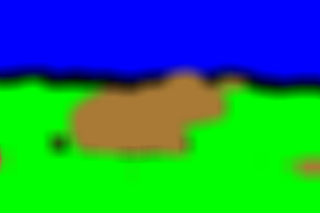

In [36]:
print("Result Image")
im(filename="predictedImage.png")

Gradient Boosting

In [26]:
def best_XG():
    model = XGBClassifier()
    param_grid = {
        'n_estimators': [200, 300, 400],
        'learning_rate': [0.1, 0.2, 0.3]
        }
    best_values = K_flode(model, param_grid)
    print(f"the best hyperparameters is :\n {best_values}")
    return best_values
best_values_xg=best_XG()

the best hyperparameters is :
 {'learning_rate': 0.2, 'n_estimators': 400}


Accuracy_Train=1.0
Accuracy_TEST:  0.944
Confusion Matrix


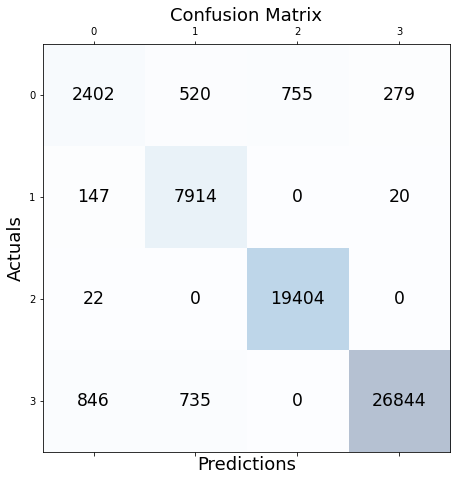

In [37]:
classifier = XGBClassifier(
    n_estimators=best_values_xg['n_estimators'], learning_rate=best_values_xg['learning_rate']
    ,tree_method='gpu_hist')
classifier.fit(x_train, y_train)
print(f"Accuracy_Train={classifier.score(x_train,y_train)}")
y_predict = predict_the_data(classifier, x_test)
print_score(y_test, y_predict)
testing_image_sizes
get_Image(y_predict=y_predict)
print("Confusion Matrix")
plot_conf_matrix(confusion_matrix(y_test, y_predict))


Result Image


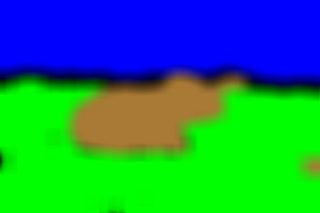

In [38]:
print("Result Image")
im(filename="predictedImage.png")